In [60]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

In [2]:
player_plays = pl.read_csv("data/player_play.csv", null_values=["NA"])
games = pl.read_csv("data/games.csv", null_values=["NA"])
plays = pl.read_csv("data/plays.csv", null_values=["NA"])
players = pl.read_csv("data/players.csv", null_values=["NA"])

In [3]:
tracking_files = glob.glob("data/tracking_week_*.csv")
tracking_data = pl.concat([pl.read_csv(f, null_values= ["NA"]) for f in tracking_files])

In [4]:
# Rename columns in `tracking_data`
tracking_data = tracking_data.rename({"s":"yardsPerSecond", "a":"acceleration","o":"orientation"})

In [126]:
tracking_data['event'].unique().to_list()

['snap_direct',
 None,
 'pass_outcome_touchdown',
 'touchback',
 'play_submit',
 'timeout_away',
 'qb_slide',
 'autoevent_passinterrupted',
 'out_of_bounds',
 'tackle',
 'huddle_start_offense',
 'pass_outcome_interception',
 'field_goal_play',
 'qb_strip_sack',
 'run',
 'safety',
 'ball_snap',
 'man_in_motion',
 'handoff',
 'fumble_offense_recovered',
 'pass_outcome_incomplete',
 'qb_sack',
 'lateral',
 'dropped_pass',
 'penalty_accepted',
 'autoevent_ballsnap',
 'qb_spike',
 'penalty_flag',
 'run_pass_option',
 'fumble_defense_recovered',
 'huddle_break_offense',
 'pass_outcome_caught',
 'first_contact',
 'pass_tipped',
 'line_set',
 'shift',
 'touchdown',
 'fumble',
 'play_action',
 'qb_kneel',
 'pass_forward',
 'autoevent_passforward',
 'pass_shovel',
 'pass_arrived']

In [ ]:
def calculate_presnap_movement(presnap:pl.DataFrame, snap:pl.DataFrame) -> pl.DataFrame:
    merged = presnap.join(snap, on='displayName', suffix='_snap')
    merged = merged.with_columns(
     (pl.col("x")-pl.col("x_snap")).alias("x_dif"),
     (pl.col("y")-pl.col("y_snap")).alias("y_dif")
    ).sort((pl.col("y_dif")))
    return merged

def determine_sides(game_df:pl.DataFrame, players_df:pl.DataFrame) -> pl.DataFrame:
    offensive_positions = {"QB", "RB", "T", "FB", "G", "C", "WR", "TE"}
    game_with_positions = game_df.join(players_df.select(["displayName", "position"]), on="displayName")
    game_with_sides = game_with_positions.with_columns(
        (pl.col("position").is_in(offensive_positions)).alias("isOffense")
    )
    return game_with_sides

def get_play_outcome(gameId:int, playId:int, plays: pl.DataFrame) -> pl.DataFrame:
    ret = plays.filter(
        (pl.col("gameId")==gameId) &
        (pl.col("playId")==playId)
    )

    return ret

def analyze_man_in_motion(game_df:pl.DataFrame, players_df:pl.DataFrame, plays_df:pl.DataFrame) -> None:
    mim_game_df = game_df.filter(
        (pl.col("event") == "man_in_motion")
    )
    plays = mim_game_df.group_by("playId", maintain_order=True)
    for play_id, play_df in plays:
        pre = play_df.filter(
            (pl.col("frameType") == "BEFORE_SNAP")
        )
        snap = game_df.filter(
            (pl.col("frameType") == "SNAP") &
            (pl.col("playId") == play_id[0])
        )
        play_side_df = determine_sides(pre, players_df)
        play_df = calculate_presnap_movement(play_side_df, snap)
        try:
            off = play_df.filter(
                (pl.col("isOffense") == True)
            ).sort((pl.col("y_dif")), descending=True)
            player= off[0]['displayName'][0]
            dis = round(off[0]['y_dif'][0], 2)
            if dis < 1:
                continue
            dir = off[0]['playDirection'][0]
            pos = off[0]['position'][0]
            print(f"Processed playId: {play_id[0]}\nPresnap movement: {pos} {player} moved {dis} yards to the {dir}.")
            determine_play_outcome(game_df.filter((pl.col("playId")==play_id[0])), plays_df)
        except:
            continue

def determine_play_outcome(play_df:pl.DataFrame, plays:pl.DataFrame) -> pl.DataFrame:
    # this needs to be verified.
    pre_snap_pos = play_df.filter(
        (pl.col("frameType") == "BEFORE_SNAP") &
        (pl.col("displayName") == "football") &
        (pl.col("event") != "None") 
    )
    post_snap_pos = play_df.filter(
        (pl.col("frameType") == "AFTER_SNAP") &
        (pl.col("displayName") == "football") &
        (pl.col("event") != "None") 
    )
    pre_coord = [pre_snap_pos["x"][0], pre_snap_pos["y"][0]]
    post_coord = [post_snap_pos["x"][0], post_snap_pos["y"][0]]
    if pre_coord == post_coord:
        print("No change in position.")
        return 0
    else:
        print(f"Ball moved from the {round(pre_coord[0])} yard line to the {round(post_coord[0])} yard line for a gain of {round(abs(post_coord[0]-pre_coord[0]), 1)}.")
        r = get_play_outcome(playId=post_snap_pos["playId"][0], gameId=post_snap_pos["gameId"][0], plays=plays)
        print(f"{r['playDescription'][0]}\n")
        return 

def build_field(ax:plt.Axes):
    # Draw field background
    ax.set_facecolor('green')
    ax.set_xlim(0, 120)   # NFL field length including end zones
    ax.set_ylim(0, 53.3)  # NFL field width

    # Add end zones
    ax.add_patch(patches.Rectangle((0, 0), 10, 53.3, linewidth=0, color='gray'))      # Home endzone
    ax.add_patch(patches.Rectangle((110, 0), 10, 53.3, linewidth=0, color='gray'))    # Visitor endzone

    # Add yard lines
    for x in range(10, 111, 10):
        ax.plot([x, x], [0, 53.3], color='white', linewidth=1.5)
        if x < 60:
            ax.text(x, 55, f'{x//10}', ha='center', color='white', fontsize=10)
            ax.text(x, -2, f'{x//10}', ha='center', color='white', fontsize=10)
        elif x > 60:
            ax.text(x, 55, f'{12 - x//10}', ha='center', color='white', fontsize=10)
            ax.text(x, -2, f'{12 - x//10}', ha='center', color='white', fontsize=10)

    # Plot sidelines
    ax.plot([0, 120], [0, 0], color='white', linewidth=2)
    ax.plot([0, 120], [53.3, 53.3], color='white', linewidth=2)
    
    # Set labels and title
    ax.set_xlabel('Field Length (Yards)')
    ax.set_ylabel('Field Width (Yards)')
    ax.set_title(f'Player Positions Pre Snap')


def show_play_presnap_scheme(play_id:int, play_df:pl.DataFrame, players:pl.DataFrame,) -> None:
    init_timestamp = play_df.filter((pl.col("playId")==play_id) &
        (pl.col("frameType")=="BEFORE_SNAP") &
        (pl.col("event") == "line_set"))
    plot_df = determine_sides(play_df, players).filter(
        (pl.col("playId")==play_id) &
        (pl.col("frameType")=="BEFORE_SNAP") &
        (pl.col("event") != "null") &
        (pl.col("time") == init_timestamp["time"][0])
    )
    off_x_coords = plot_df.filter((pl.col("isOffense")== True))['x'].to_numpy()
    off_y_coords = plot_df.filter((pl.col("isOffense") == True))['y'].to_numpy()
    def_x_coords = plot_df.filter((pl.col("isOffense") == False))['x'].to_numpy()
    def_y_coords = plot_df.filter((pl.col("isOffense") == False))['y'].to_numpy()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6.33))

    build_field(ax)

    # Plot x and y coordinates
    ax.scatter(off_x_coords, off_y_coords, color="red", s=50, alpha=0.7, label="Offense")
    ax.scatter(def_x_coords, def_y_coords, color="blue", s=50, alpha=0.7, label="Defense")
    ax.legend(loc='upper right')
    plt.show()


def show_play_aftersnap_scheme(play_id:int, play_df:pl.DataFrame, players:pl.DataFrame,) -> None:
    plot_df = determine_sides(play_df, players).filter(
        (pl.col("playId")==play_id) &
        (pl.col("frameType")=="AFTER_SNAP") &
        (pl.col("event") != "null")
    )

    plot_df=plot_df.filter(
        (pl.col("time") == plot_df["time"][-1])
    )
    off_x_coords = plot_df.filter((pl.col("isOffense")== True))['x'].to_numpy()
    off_y_coords = plot_df.filter((pl.col("isOffense") == True))['y'].to_numpy()
    def_x_coords = plot_df.filter((pl.col("isOffense") == False))['x'].to_numpy()
    def_y_coords = plot_df.filter((pl.col("isOffense") == False))['y'].to_numpy()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6.33))
    build_field(ax)
    

    # Plot x and y coordinates
    ax.scatter(off_x_coords, off_y_coords, color="red", s=50, alpha=0.7, label="Offense")
    ax.scatter(def_x_coords, def_y_coords, color="blue", s=50, alpha=0.7, label="Defense")
    ax.legend(loc='upper right')
    plt.show()



In [6]:
gameIdArr = tracking_data["gameId"].unique()

In [24]:
test_game = tracking_data.filter(
    (pl.col("gameId") == gameIdArr[1])
)

In [ ]:
test_game

In [161]:
analyze_man_in_motion(test_game, players, plays)

Processed playId: 57
Presnap movement: WR Olamide Zaccheaus moved 8.68 yards to the right.
Ball moved from the 35 yard line to the 30 yard line for a gain of 4.8.
(15:00) (Shotgun) M.Mariota scrambles right end to ATL 36 for 11 yards (P.Werner).

Processed playId: 78
Presnap movement: TE Parker Hesse moved 9.06 yards to the right.
Ball moved from the 46 yard line to the 41 yard line for a gain of 5.1.
(14:19) C.Patterson left tackle to ATL 42 for 6 yards (T.Mathieu).

Processed playId: 145
Presnap movement: TE Kyle Pitts moved 4.54 yards to the right.
Ball moved from the 56 yard line to the 52 yard line for a gain of 4.3.
(12:57) (Shotgun) D.Williams right guard to ATL 49 for 2 yards (K.Street; P.Werner).

Processed playId: 212
Presnap movement: WR Drake London moved 10.7 yards to the right.
Ball moved from the 69 yard line to the 66 yard line for a gain of 3.6.
(11:34) (Shotgun) M.Mariota right end to NO 35 for 5 yards (P.Werner).

Processed playId: 395
Presnap movement: FB Keith Smit

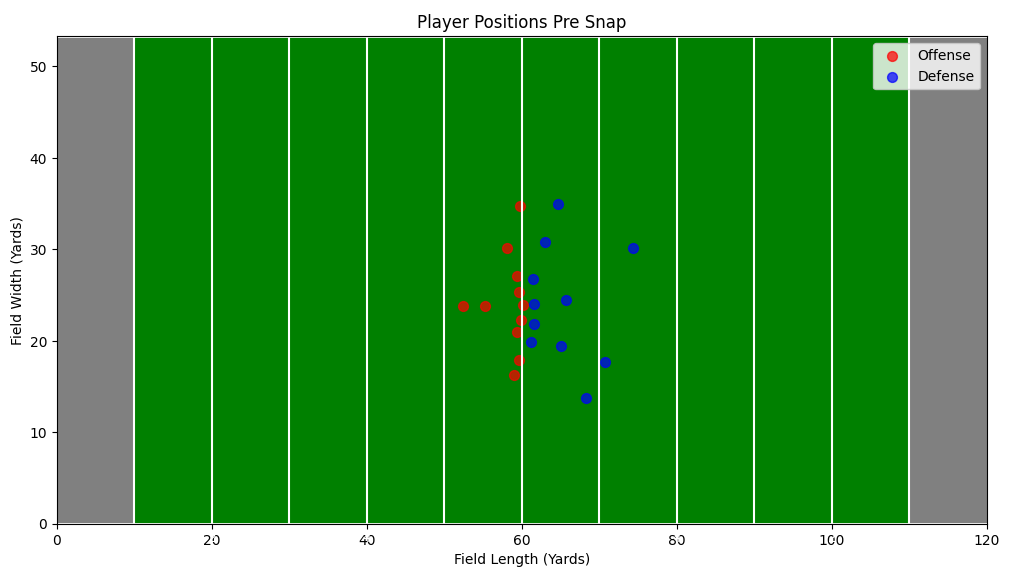

In [123]:
show_play_presnap_scheme(914, test_game, players)

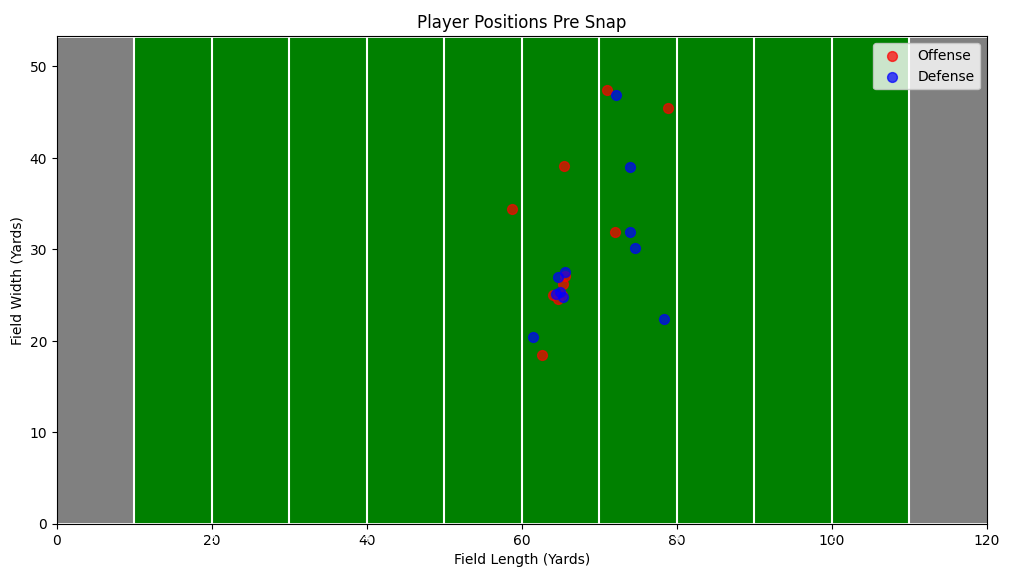

In [124]:
show_play_aftersnap_scheme(914, test_game, players)